# Shapley value 계산을 위한 value function의 형태 측정

In [1]:
import os; os.chdir("../")

In [2]:
import random
import functools
import logging
import pickle
from math import comb

import torch
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm

from models.tab_resnet import TabResNet
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, ExpSineSquared
from script.evaluate import _invert_input_array, _transform, find_closest_data_with_center

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2025-03-26 17:20:45.749016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 17:20:47.320467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477

In [3]:
# dataset_nm = "Adult"
dataset_nm = "Wine Quality"
X_train = np.load(f"data/{dataset_nm}/X_train.npy")
y_train = np.load(f"data/{dataset_nm}/y_train.npy")

X_test = np.load(f"data/{dataset_nm}/X_test.npy")
y_test = np.load(f"data/{dataset_nm}/y_test.npy")

feature_metadata = pickle.load(open(f"data/{dataset_nm}/feature_metadata.pkl", "rb"))
raw_data = pd.read_csv(f"data/{dataset_nm}/raw_data.csv")
invert_input_array = functools.partial(_invert_input_array, feature_metadata=feature_metadata)
transform = functools.partial(_transform, feature_metadata=feature_metadata)

kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(X_train)

res = kmeans.predict(X_train)
_, counts = np.unique(res, return_counts=True)
weight = counts / counts.sum()

bg_data_arr = find_closest_data_with_center(X_train, kmeans.cluster_centers_)
bg_data = invert_input_array(bg_data_arr)
train_data = invert_input_array(X_train)

model = TabResNet(X_train.shape[1], 2, num_blocks=1)
model.load_state_dict(torch.load(f"data/{dataset_nm}/resnet_model.pth"))
model.eval()

_model = "tab_resnet"
framework = "pnpxai"
explainer = "shap"
path = f"results/{dataset_nm}/{_model}/{framework}/{explainer}"
explanation = np.load(f"{path}/explanations.npy")

In [4]:
def vf_converter(X_test, bg_data, model, transform, weight):
    orig_feature = bg_data.columns.copy()
    target = invert_input_array(X_test)
    proba = model.predict_proba(transform(target))
    pred_label = proba.argmax()

    def value_function(bin_coal):
        coalition = np.where(bin_coal == 1)[0]
        coal_feature = orig_feature[coalition]
        non_coal_feature = [col for col in orig_feature if col not in coal_feature]

        coal_data = target.loc[target.index.repeat(len(bg_data)), coal_feature].reset_index(drop=True)
        non_coal_data = bg_data.loc[np.tile(bg_data.index, len(target))].reset_index(drop=True)[non_coal_feature]
        new_data = pd.concat([coal_data, non_coal_data], axis=1)[orig_feature]

        input_data = transform(new_data)
        pred = model.predict_proba(input_data)[:, pred_label]

        return (pred * weight).sum(), input_data
    return value_function


n = len(feature_metadata)
input_vector = np.array([[int(x) for x in format(i, f'0{n}b')] for i in range(2**n)])
# grey_list = [i ^ (i >> 1) for i in range(2**n)]
# input_vector = np.array([[int(x) for x in format(i, f'0{n}b')] for i in grey_list])

# binary_list = [format(i, f'0{n}b') for i in range(2**n)]
    
# Cardinality 기준 정렬 + 같은 경우 사전순 정렬
# sorted_binary_list = sorted(binary_list, key=lambda x: (x.count('1'), int(x, 2)))
# input_vector = np.array([[int(x) for x in binary] for binary in sorted_binary_list])


In [5]:
embedding_model = umap.UMAP(n_components=2, random_state=42)
embedding_model.fit(X_train)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [6]:
i = 0
vf = vf_converter(X_test[[i]], bg_data, model, transform, weight)
v_val, points = vf(input_vector[0])

In [8]:
# base_point = embedding_model.transform(points[[0]])
# target_point = embedding_model.transform(X_test[[i]])
# bg_points = embedding_model.transform(bg_data)

with torch.no_grad():
    base_point = model.network(torch.tensor(points[[0]], dtype=torch.float32))
    target_point = model.network(torch.tensor(X_test[[i]], dtype=torch.float32))
    bg_points = model.network(torch.tensor(bg_data.values, dtype=torch.float32))

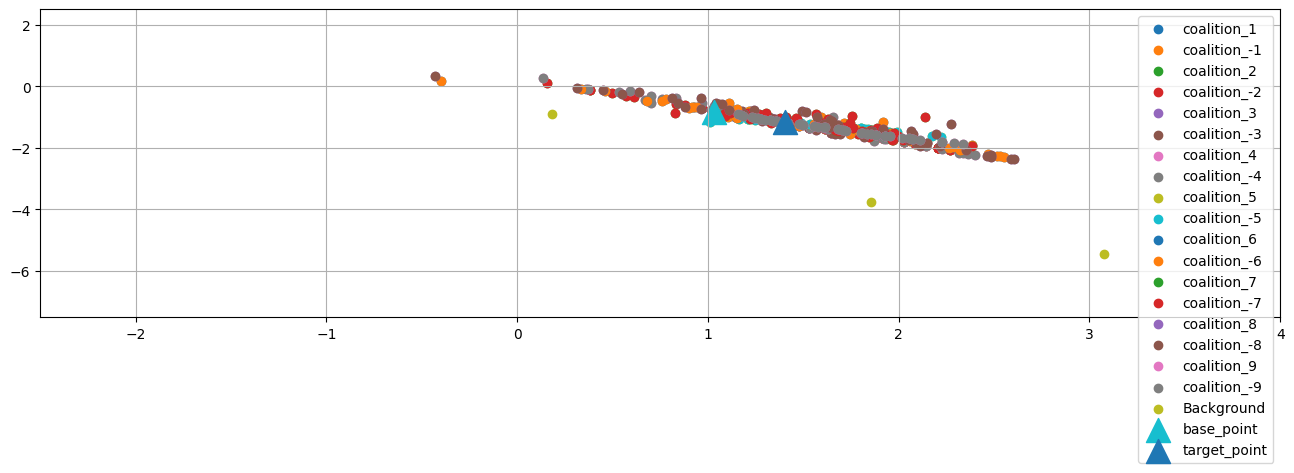

In [11]:
plt.figure(figsize=(16,4))
for coal_idx in range(1,10):
    with torch.no_grad():
        v_val, points = vf(input_vector[-coal_idx])
        coalition = model.network(torch.tensor(points, dtype=torch.float32))
        plt.scatter(coalition[:,0], coalition[:,1], label=f"coalition_{coal_idx}")
        v_val, points = vf(input_vector[-coal_idx])
        coalition = model.network(torch.tensor(points, dtype=torch.float32))
        plt.scatter(coalition[:,0], coalition[:,1], label=f"coalition_{-coal_idx}")
plt.scatter(bg_points[:,0], bg_points[:,1], label="Background")
plt.scatter(base_point[:,0], base_point[:,1], label="base_point", s=300, marker="^")
plt.scatter(target_point[:,0], target_point[:,1], label="target_point", s=300, marker="^")
plt.legend()
plt.grid()
plt.xlim(-2.5,4)
plt.ylim(-7.5,2.5)
plt.show()

100%|██████████| 16/16 [03:23<00:00, 12.74s/it]


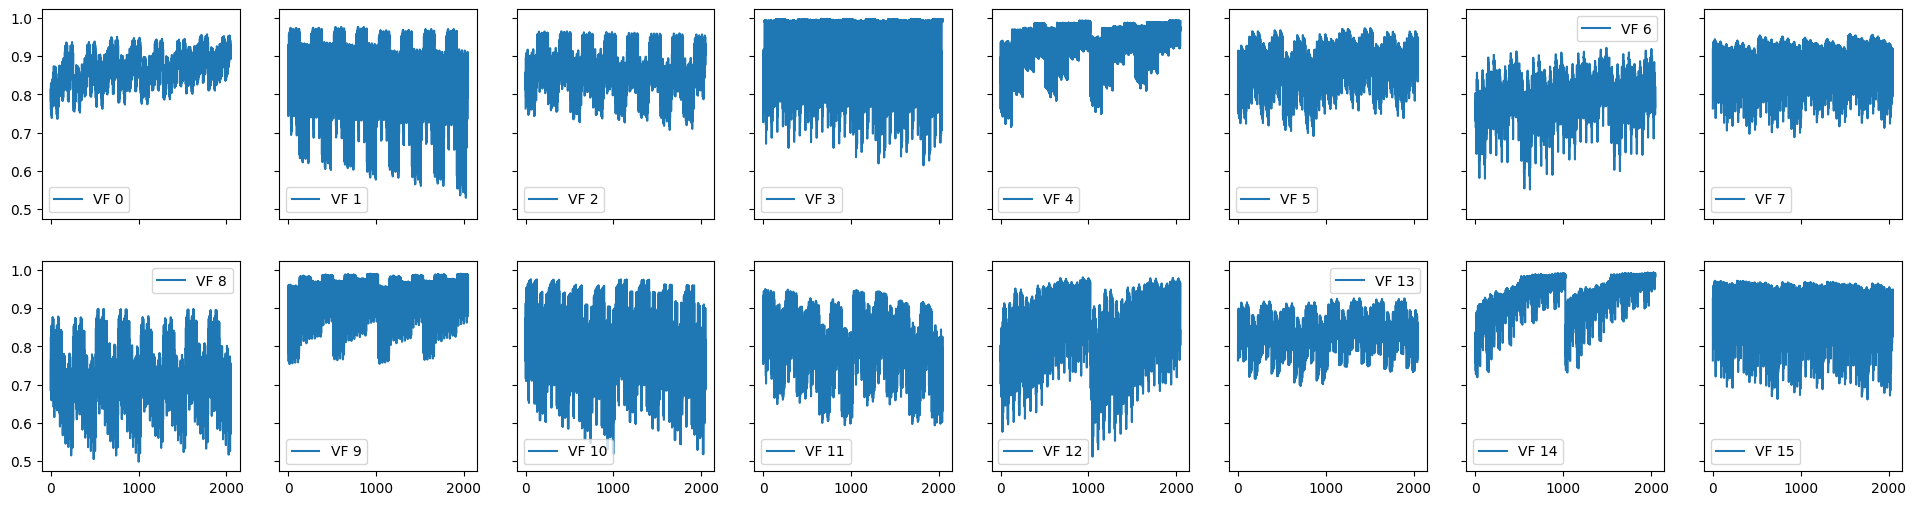

In [ ]:
data_size = 16
h = 8
v = data_size // h
fig, axes = plt.subplots(v, h, figsize=(h*3, v*3), sharex=True, sharey=True)
flatten_axes = axes.flatten()
vf_values = np.zeros((data_size, 2**n))
for i in tqdm(range(data_size)):
    vf = vf_converter(X_test[[i]], bg_data, model, transform, weight)
    vf_values[i] = np.array([vf(x) for x in input_vector])
    flatten_axes[i].plot(vf_values[i], label=f"VF {i}")
    flatten_axes[i].legend()
plt.show()

In [ ]:
def shapley_kernel(N):
    kernel = np.zeros(N+1)
    for s in range(1, N):  # subset 크기 s는 1부터 N-1까지
        kernel[s] = (N - 1) / (comb(N, s) * s * (N - s))
    return kernel / kernel.sum()
sk = shapley_kernel(input_vector.shape[1])

for idx in range(16):
    X = input_vector - input_vector.mean(axis=0)
    y = vf_values[idx]-vf_values[idx,0]
    W = np.diag(sk[input_vector.sum(axis=1)])
        
    # 정규 방정식을 통해 계수 추정
    beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)

    _error = y - X @ beta
    alpha = _error.mean()
    error = _error - alpha
    rsq = 1-(error**2).sum() / (y**2).sum()
    print("Shapley value : ", beta)

Shapley value :  [ 0.02099247  0.02061873  0.00322862  0.0391962  -0.00042974  0.03954252
  0.01380171 -0.00976807 -0.01755089  0.0082635   0.04515192]
Shapley value :  [-1.87040184e-02 -5.59480726e-03 -3.90466516e-03 -9.15330786e-02
 -2.24665398e-03 -1.68825715e-02  9.30899560e-02  6.55798100e-02
 -9.05449582e-05 -1.75593810e-02  1.19268025e-01]
Shapley value :  [-0.01278807 -0.00869388  0.00178018  0.06990134 -0.00256566 -0.01106397
  0.02623325 -0.00272634  0.01990041  0.03173692  0.06719982]
Shapley value :  [-0.01574483  0.00056992 -0.00657141  0.02304933  0.00072961 -0.02104814
  0.16820723  0.01530421  0.01113937 -0.02445946  0.06798539]
Shapley value :  [ 0.01192561  0.02941945  0.05292231  0.02794665 -0.00079557 -0.00498395
 -0.00386074 -0.00454724 -0.00030201  0.03763697  0.0786172 ]
Shapley value :  [ 0.02563402 -0.01583995  0.00136932  0.04265589 -0.00092924  0.02990977
 -0.01361487 -0.01274042 -0.0102605   0.01996573  0.10714838]
Shapley value :  [ 0.02418254 -0.01174474  

In [ ]:
X_test[0], X_test[[0]] * np.random.uniform(0.95,1.05, X_test.shape[1])

(array([-0.86035472,  0.42724077, -0.54115347, -0.80783726, -0.20079018,
        -0.81841851,  0.37608571, -0.56583843,  0.63131247, -0.21014415,
        -0.07697409]),
 array([[-0.8524862 ,  0.43419194, -0.54423956, -0.78265032, -0.2065526 ,
         -0.81035357,  0.39150667, -0.55166945,  0.65730953, -0.20349661,
         -0.07900946]]))

In [ ]:
h = 0.9
vf = vf_converter(X_test[[0]] * np.random.uniform(1-h,1+h, X_test.shape[1]), bg_data, model, transform, weight)
vf_pt = np.array([vf(x) for x in input_vector])

In [ ]:
X = input_vector - input_vector.mean(axis=0)
y = vf_pt-vf_pt[0]
W = np.diag(sk[input_vector.sum(axis=1)])
    
# 정규 방정식을 통해 계수 추정
beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)

_error = y - X @ beta
alpha = _error.mean()
error = _error - alpha
rsq = 1-(error**2).sum() / (y**2).sum()
print("Shapley value : ", beta)

Shapley value :  [ 0.00506298  0.00365317  0.0014886   0.07909542 -0.00268209  0.00314567
  0.02645769 -0.02580602 -0.00423341  0.01147147  0.04656185]


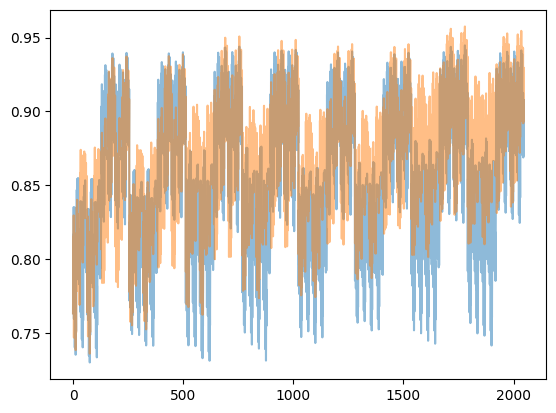

In [ ]:
plt.plot(vf_pt, alpha=0.5)
plt.plot(vf_values[0], alpha=0.5)
plt.show()


In [ ]:
record = {"d1" : [], "d2" : []}
for i in range(16):
    for j in range(16):
        d1 = ((X_test[i] - X_test[j])**2).sum()
        d2 = ((vf_values[i] - vf_values[j])**2).sum()
        record["d1"].append(d1)
        record["d2"].append(d2)


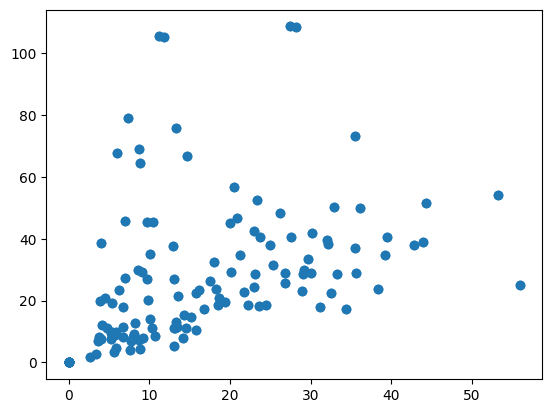

In [ ]:
# sorted_idx = 
plt.scatter(record["d1"], record["d2"])

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Pred')

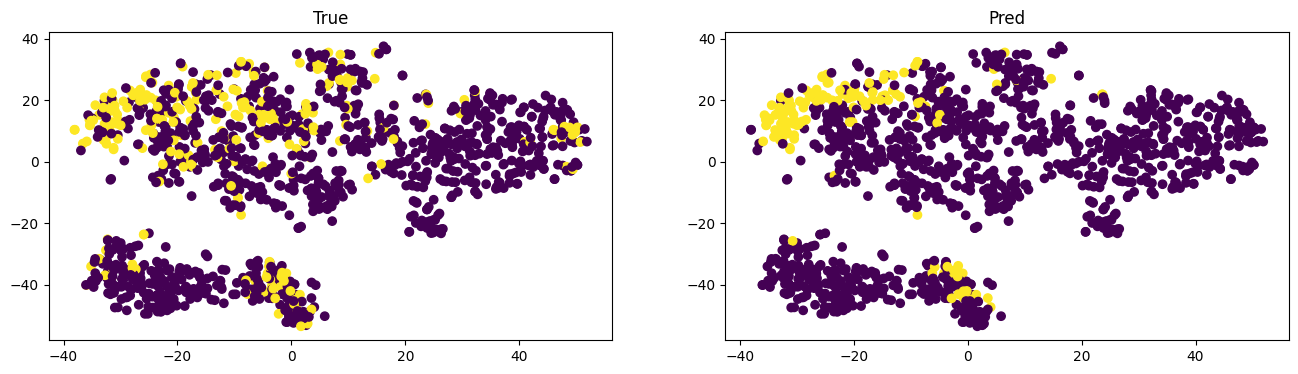

In [ ]:
pred = model.predict_proba(X_test).argmax(axis=1)
embedding_model = TSNE(n_components=2)
pred_tsne = embedding_model.fit_transform(X_test)
fig, axes = plt.subplots(1,2,figsize=(16,4))
axes[0].scatter(pred_tsne[:,0], pred_tsne[:,1], c=y_test)
axes[1].scatter(pred_tsne[:,0], pred_tsne[:,1], c=pred)
axes[0].set_title("True")
axes[1].set_title("Pred")

In [ ]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
from sklearn.gaussian_process.kernels import Kernel, NormalizedKernelMixin, StationaryKernelMixin

In [ ]:
class MyKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self):
        pass
    
    def __call__(self, X, Y=None, eval_gradient=False):
        if eval_gradient:
            raise ValueError("HERE")
        
        if Y is None:
            return np.eye(X.shape[0])

class RBFhack(RBF):
    def __call__(self, X, Y=None, eval_gradient=False):
        super().__call__(X,Y,eval_gradient)
        if eval_gradient:
            raise ValueError("HERE")

In [ ]:
tmp = vf_values
train_data = tmp[:-1]
feature_idx = 0
kernel = RBFhack()
# kernel = MyKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
gp_model.fit(train_data, explanation[:15, feature_idx])

ValueError: HERE

In [ ]:
RBF("A","B")

ValueError: Unknown format code 'g' for object of type 'numpy.str_'

In [ ]:
explanation[0]

array([ 0.01417926,  0.0329542 ,  0.00650236,  0.13669953, -0.01767989,
        0.07199831,  0.03804327, -0.04953171, -0.00353985, -0.00390133,
        0.01240374])

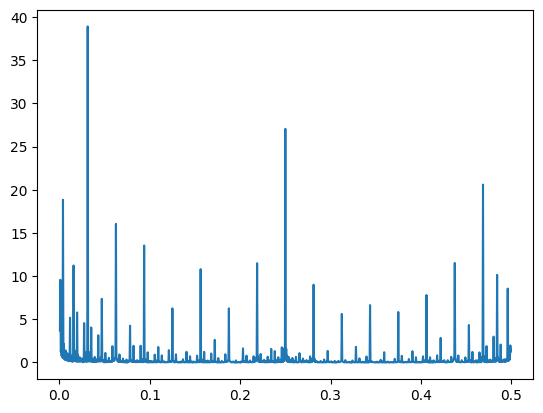

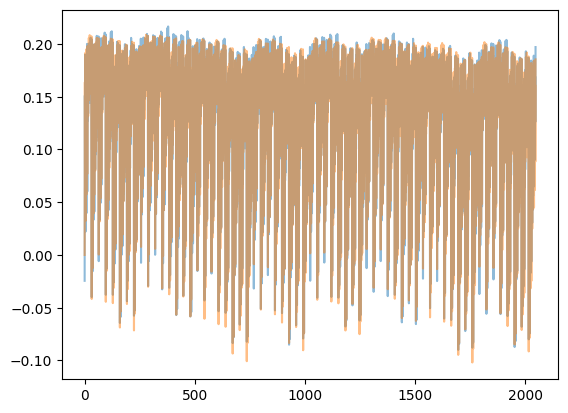

In [ ]:
idx = 15
fft_signal = np.fft.fft(vf_values[idx]-vf_values[idx,0])
abs_fft_signal = np.abs(fft_signal)
freqs = np.fft.fftfreq(len(abs_fft_signal))
plt.plot(freqs[1:len(abs_fft_signal)//2], abs_fft_signal[1:len(abs_fft_signal)//2])
plt.show()

# Inverse Fourier Transform with only top 10 frequencies
top_k = 100
top_k_idx = np.argsort(abs_fft_signal)[::-1][top_k:]
fft_signal[top_k_idx] = 0
reconstructed_signal = np.fft.ifft(fft_signal)
plt.plot(reconstructed_signal.real, alpha=0.5)
plt.plot(vf_values[idx]-vf_values[idx,0], alpha=0.5)
plt.show()

In [ ]:
def shapley_kernel(N):
    kernel = np.zeros(N+1)
    for s in range(1, N):  # subset 크기 s는 1부터 N-1까지
        kernel[s] = (N - 1) / (comb(N, s) * s * (N - s))
    return kernel / kernel.sum()
sk = shapley_kernel(input_vector.shape[1])

In [ ]:
X = input_vector - input_vector.mean(axis=0)
y = vf_values[idx]-vf_values[idx,0]
W = np.diag(sk[input_vector.sum(axis=1)])
    
# 정규 방정식을 통해 계수 추정
beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)

_error = y - X @ beta
alpha = _error.mean()
error = _error - alpha
rsq = 1-(error**2).sum() / (y**2).sum()
print("Shapley value : ", beta)
print("R^2 : ", rsq)

Shapley value :  [-0.00545275 -0.01556156  0.00204159 -0.0302972  -0.0020475  -0.02004867
  0.06046738  0.02443495  0.01015967  0.03694547  0.11264372]
R^2 :  0.9655463117798015


In [ ]:
X = input_vector - input_vector.mean(axis=0)
y = reconstructed_signal.real
W = np.diag(sk[input_vector.sum(axis=1)])
    
# 정규 방정식을 통해 계수 추정
beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)

_error = y - X @ beta
alpha = _error.mean()
error = _error - alpha
rsq = 1-(error**2).sum() / (y**2).sum()
print("Shapley value : ", beta)
print("R^2 : ", rsq)

Shapley value :  [-0.00631577 -0.01127499  0.00140618 -0.02600326  0.0004394  -0.0162843
  0.06305184  0.0236397   0.01130874  0.03764585  0.10829857]
R^2 :  0.9663543704584144


In [ ]:
# tmp = vf_values[:, ::20]
tmp = vf_values
train_data = tmp[:-1]
test_data = tmp[-1]

In [ ]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

for feature_idx in range(11):
    # kernel = RBF(10, (1e-2, 1e2))
    kernel = (
        RBF(10, (1e-2, 1e2))
        # C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        # C(1.0) + RBF(10)
        # ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-5, 1e2), periodicity_bounds=(1e-5, 1e2))
    )
    gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    gp_model.fit(train_data, explanation[:15, feature_idx])
    print(gp_model.predict(test_data.reshape(1, -1), return_std=True))

(array([0.00989913]), array([0.04095995]))
(array([-0.07600173]), array([0.03060318]))
(array([-0.00808153]), array([0.03657524]))
(array([-0.00583429]), array([0.05109167]))
(array([-0.00271507]), array([0.01931687]))
(array([-0.02015945]), array([0.02995173]))
(array([0.07244988]), array([0.03375129]))
(array([0.02833003]), array([0.07399355]))
(array([0.04035838]), array([0.03632097]))
(array([0.03874851]), array([0.03436553]))
(array([0.16806475]), array([0.03613631]))


In [ ]:
kernel = (
    # RBF(10, (1e-2, 1e2))
    C(1.0, (1e-3, 1e3)) *
    ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-2, 1e2), periodicity_bounds=(1e-2, 1e2)) *
    ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-2, 1e2), periodicity_bounds=(1e-2, 1e2))
)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1000)

gp_model.fit(train_data, explanation[:15, feature_idx])
res = gp_model.kernel_(train_data)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
gp_model.kernel_.get_params()

{'k1': 0.282**2 * ExpSineSquared(length_scale=10.6, periodicity=5.5),
 'k2': ExpSineSquared(length_scale=0.813, periodicity=100),
 'k1__k1': 0.282**2,
 'k1__k2': ExpSineSquared(length_scale=10.6, periodicity=5.5),
 'k1__k1__constant_value': 0.07938392422015274,
 'k1__k1__constant_value_bounds': (0.001, 1000.0),
 'k1__k2__length_scale': 10.595408363442862,
 'k1__k2__periodicity': 5.496045223021046,
 'k1__k2__length_scale_bounds': (0.01, 100.0),
 'k1__k2__periodicity_bounds': (0.01, 100.0),
 'k2__length_scale': 0.8129243009385821,
 'k2__periodicity': 99.99999999999994,
 'k2__length_scale_bounds': (0.01, 100.0),
 'k2__periodicity_bounds': (0.01, 100.0)}

In [ ]:
gp_model.kernel_(train_data)

array([[0.07938392, 0.07398463, 0.07711408, 0.07395179, 0.07559782,
        0.07750625, 0.07442398, 0.07608484, 0.06457567, 0.07581889,
        0.07264593, 0.07335892, 0.07458614, 0.07608772, 0.07530276],
       [0.07398463, 0.07938392, 0.07390692, 0.07406238, 0.07186746,
        0.07373374, 0.07014359, 0.0760766 , 0.06416683, 0.07294505,
        0.07640633, 0.0758334 , 0.07017131, 0.07477276, 0.07155687],
       [0.07711408, 0.07390692, 0.07938392, 0.07447608, 0.07558815,
        0.07700778, 0.07438315, 0.07621798, 0.06376877, 0.07613569,
        0.07230232, 0.07324935, 0.07295237, 0.07554507, 0.07466773],
       [0.07395179, 0.07406238, 0.07447608, 0.07938392, 0.07380793,
        0.07288079, 0.06824036, 0.07430627, 0.05797534, 0.07404168,
        0.06963763, 0.06859661, 0.06682409, 0.0707074 , 0.0736185 ],
       [0.07559782, 0.07186746, 0.07558815, 0.07380793, 0.07938392,
        0.07557715, 0.06886513, 0.07519563, 0.05837581, 0.07827281,
        0.06777597, 0.06901649, 0.07076822, 

In [ ]:
gp_model.kernel_(test_data.reshape(1, -1), train_data)

array([[0.07559206, 0.07590745, 0.07610677, 0.07509508, 0.07552266,
        0.07569789, 0.07147518, 0.07781105, 0.06208501, 0.07600661,
        0.07416313, 0.07453293, 0.07052393, 0.07537536, 0.07477671]])

In [ ]:
print(gp_model.predict(test_data.reshape(1, -1), return_std=True))

(array([0.197047]), array([0.]))


/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:432: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


In [ ]:
explanation[:15, feature_idx], explanation[15]

(array([ 0.01240374,  0.20153481,  0.02304797,  0.13446277,  0.15975106,
         0.10410559, -0.10964072,  0.15112811, -0.16735983,  0.18419069,
         0.07167862,  0.1991006 ,  0.0363496 ,  0.01322264,  0.08197884]),
 array([ 0.03156069, -0.06824457,  0.02107066, -0.12039022,  0.03579374,
        -0.00952714,  0.06234358,  0.00740106,  0.0356125 ,  0.10106707,
         0.16079018]))

In [ ]:
STOP

NameError: name 'STOP' is not defined